In [47]:
import gc
import json
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import scipy.sparse
import seaborn as sns
import statsmodels.api as sm
import string
import warnings

from collections import Counter
from datetime import datetime
from IPython.display import display, HTML
from nltk.corpus import stopwords
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, classification_report, silhouette_score, calinski_harabasz_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols
from statsmodels.stats.api import anova_lm
from textblob import TextBlob
from wordcloud import WordCloud

warnings.filterwarnings('ignore')

%matplotlib inline

STAGE 1 - TRAIN/TEST SPLIT

In [48]:
#Perform train/test split with stratification
def load_and_preprocess_data(filepath, chunk_size=10000):
    chunks = []
    try:
        for chunk in pd.read_csv(filepath, chunksize=chunk_size):
            date_columns = ['local_date_posted', 'date_of_experience', 'date_posted']
            for col in date_columns:
                if col in chunk.columns:
                    chunk[col] = pd.to_datetime(chunk[col])
            chunks.append(chunk)
        df = pd.concat(chunks, ignore_index=True)
        initial_rows = len(df)
        df = df.dropna()
        rows_dropped = initial_rows - len(df)
        print(f"Loaded {len(df)} rows")
        print(f"Dropped {rows_dropped} rows with null values")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

def split_data(df, test_size=0.2):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42, stratify=df['rating'])
    print(f"Training set size: {len(train_df)}")
    print(f"Test set size: {len(test_df)}")
    return train_df, test_df

def ensure_index_tracking(train_df, test_df):
    train_df = train_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)
    train_df['row_id'] = ['train_' + str(i) for i in range(len(train_df))]
    test_df['row_id'] = ['test_' + str(i) for i in range(len(test_df))]
    return train_df, test_df

def save_processed_matrices(X_train_tfidf, X_test_tfidf, X_train_bow, X_test_bow, 
                          tfidf_vectorizer, count_vectorizer, train_df, test_df):
    scipy.sparse.save_npz('data/X_train_tfidf.npz', X_train_tfidf)
    scipy.sparse.save_npz('data/X_test_tfidf.npz', X_test_tfidf)
    scipy.sparse.save_npz('data/X_train_bow.npz', X_train_bow)
    scipy.sparse.save_npz('data/X_test_bow.npz', X_test_bow)
    np.save('data/text_features.npy', {
        'tfidf_features': tfidf_vectorizer.get_feature_names_out(),
        'bow_features': count_vectorizer.get_feature_names_out(),
        'train_ids': train_df['row_id'].values,
        'test_ids': test_df['row_id'].values})
    
df = load_and_preprocess_data('data/data_trustpilot_2.csv')
train_df, test_df = split_data(df)

Loaded 320049 rows
Dropped 38 rows with null values
Training set size: 256039
Test set size: 64010


STAGE 2 - HANDLE OUTLIERS

In [49]:
# Handling outliers
def handle_outliers(train_df, test_df, columns):
    bounds = {}
    for col in columns:
        Q1 = train_df[col].quantile(0.25)
        Q3 = train_df[col].quantile(0.75)
        IQR = Q3 - Q1
        bounds[col] = {
            'lower': Q1 - 1.5 * IQR,
            'upper': Q3 + 1.5 * IQR}
        train_df[col] = train_df[col].clip(bounds[col]['lower'], bounds[col]['upper'])
        test_df[col] = test_df[col].clip(bounds[col]['lower'], bounds[col]['upper'])
    return train_df, test_df, bounds

STAGE 3 - ADVANCED TEXT PREPROCESSING

In [50]:
def process_text_features(train_df, test_df):
    tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df=10, max_df=0.5, 
        max_features=50000, stop_words='english')
    count_vec = CountVectorizer(ngram_range=(1, 2),  min_df=10, max_df=0.5,
        max_features=50000, stop_words='english')
    
    print("Creating TF-IDF features...")
    X_train_tfidf = tfidf.fit_transform(train_df['text_processed'])
    X_test_tfidf = tfidf.transform(test_df['text_processed'])
    print(f"TF-IDF features created:")
    print(f"Training shape: {X_train_tfidf.shape}")
    print(f"Test shape: {X_test_tfidf.shape}")
    print(f"Number of unique TF-IDF features: {len(tfidf.get_feature_names_out())}")
    print("Creating BoW features...")
    X_train_bow = count_vec.fit_transform(train_df['text_processed'])
    X_test_bow = count_vec.transform(test_df['text_processed'])
    print(f"BoW features created:")
    print(f"Training shape: {X_train_bow.shape}")
    print(f"Test shape: {X_test_bow.shape}")
    print(f"Number of unique BoW features: {len(count_vec.get_feature_names_out())}")
    
    save_sparse_matrices(X_train_tfidf, X_test_tfidf, X_train_bow, X_test_bow, tfidf, count_vec)
    
    return {'tfidf': {'vectorizer': tfidf, 'train': X_train_tfidf, 'test': X_test_tfidf},
        'bow': {'vectorizer': count_vec, 'train': X_train_bow, 'test': X_test_bow}}

def save_sparse_matrices(X_train_tfidf, X_test_tfidf, X_train_bow, X_test_bow, tfidf_vectorizer, count_vectorizer):
    scipy.sparse.save_npz('data/X_train_tfidf.npz', X_train_tfidf)
    scipy.sparse.save_npz('data/X_test_tfidf.npz', X_test_tfidf)
    scipy.sparse.save_npz('data/X_train_bow.npz', X_train_bow)
    scipy.sparse.save_npz('data/X_test_bow.npz', X_test_bow)
    np.save('data/text_features.npy', {'tfidf_features': tfidf_vectorizer.get_feature_names_out(),
        'bow_features': count_vectorizer.get_feature_names_out()})

feature_matrices = process_text_features(train_df, test_df)

Creating TF-IDF features...
TF-IDF features created:
Training shape: (256039, 50000)
Test shape: (64010, 50000)
Number of unique TF-IDF features: 50000
Creating BoW features...
BoW features created:
Training shape: (256039, 50000)
Test shape: (64010, 50000)
Number of unique BoW features: 50000


STAGE 4 - CLUSTERING


Evaluating tfidf_sentiment strategy:

Clustering Results (k=2):
Silhouette Score: 0.477
Calinski-Harabasz Score: 5278.535

Cluster Size Distribution:
Cluster 0: 256038 samples (100.0%)
Cluster 1: 1 samples (0.0%)


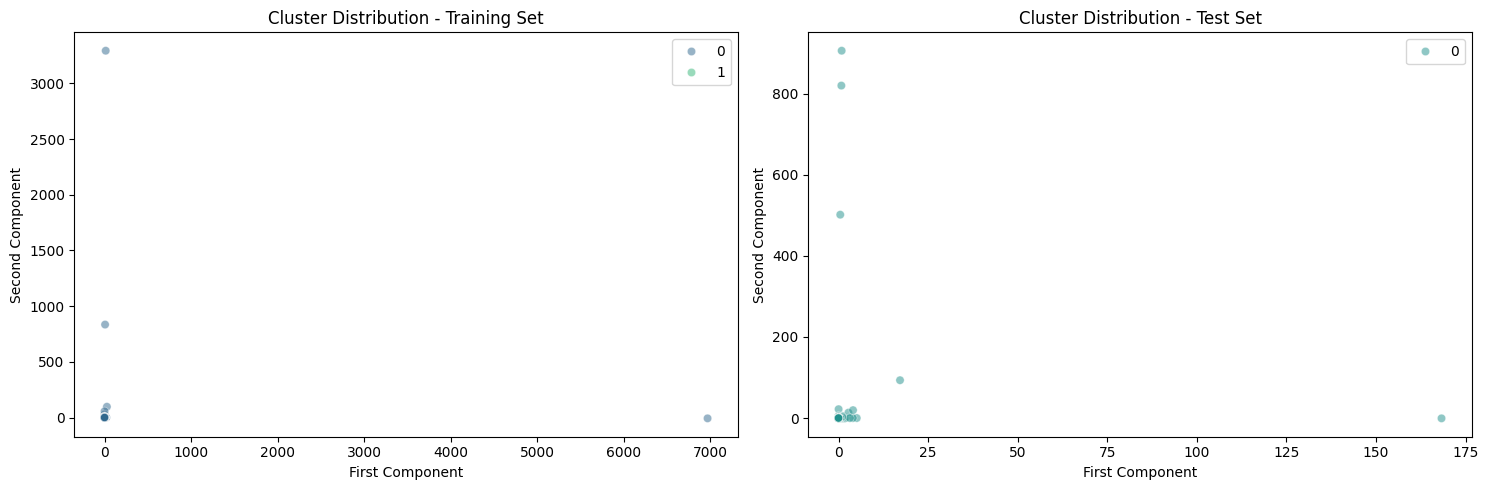


Cluster Analysis:
--------------------------------------------------

Cluster 0:
Size: 256038 samples (100.0%)
Center: (0.04, 0.06)
Spread: 13.77, 6.72

Cluster 1:
Size: 1 samples (0.0%)
Center: (0.08, 0.52)
Spread: nan, nan

Evaluating topic_modeling strategy:

Clustering Results (k=9):
Silhouette Score: 0.509
Calinski-Harabasz Score: 118615.329

Cluster Size Distribution:
Cluster 0: 38850 samples (15.2%)
Cluster 1: 21620 samples (8.4%)
Cluster 2: 34742 samples (13.6%)
Cluster 3: 36522 samples (14.3%)
Cluster 4: 19044 samples (7.4%)
Cluster 5: 25349 samples (9.9%)
Cluster 6: 40280 samples (15.7%)
Cluster 7: 18415 samples (7.2%)
Cluster 8: 21217 samples (8.3%)


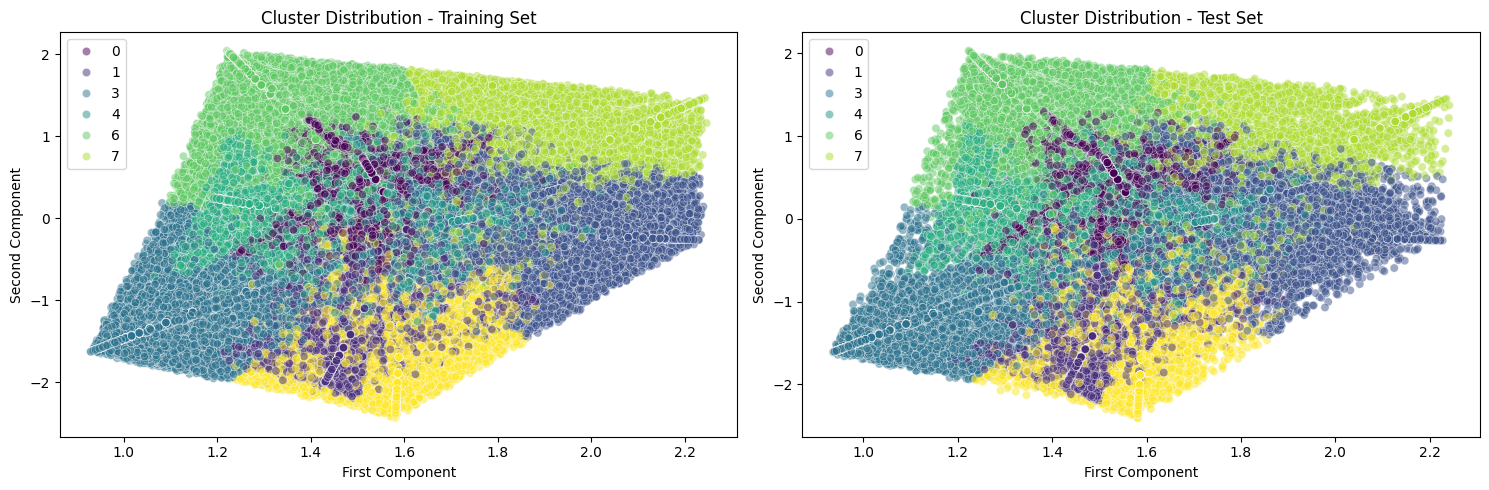


Cluster Analysis:
--------------------------------------------------

Cluster 0:
Size: 38850 samples (15.2%)
Center: (1.53, 0.50)
Spread: 0.09, 0.36

Cluster 1:
Size: 21620 samples (8.4%)
Center: (1.48, -1.48)
Spread: 0.09, 0.47

Cluster 2:
Size: 34742 samples (13.6%)
Center: (1.88, 0.11)
Spread: 0.16, 0.46

Cluster 3:
Size: 36522 samples (14.3%)
Center: (1.10, -1.29)
Spread: 0.13, 0.33

Cluster 4:
Size: 19044 samples (7.4%)
Center: (1.69, 0.01)
Spread: 0.12, 0.38

Cluster 5:
Size: 25349 samples (9.9%)
Center: (1.31, 0.18)
Spread: 0.11, 0.30

Cluster 6:
Size: 40280 samples (15.7%)
Center: (1.33, 1.48)
Spread: 0.10, 0.42

Cluster 7:
Size: 18415 samples (7.2%)
Center: (1.91, 0.90)
Spread: 0.17, 0.47

Cluster 8:
Size: 21217 samples (8.3%)
Center: (1.58, -1.67)
Spread: 0.10, 0.53

Evaluating hybrid strategy:

Clustering Results (k=10):
Silhouette Score: 0.308
Calinski-Harabasz Score: 42066.954

Cluster Size Distribution:
Cluster 0: 21454 samples (8.4%)
Cluster 1: 4892 samples (1.9%)
Clust

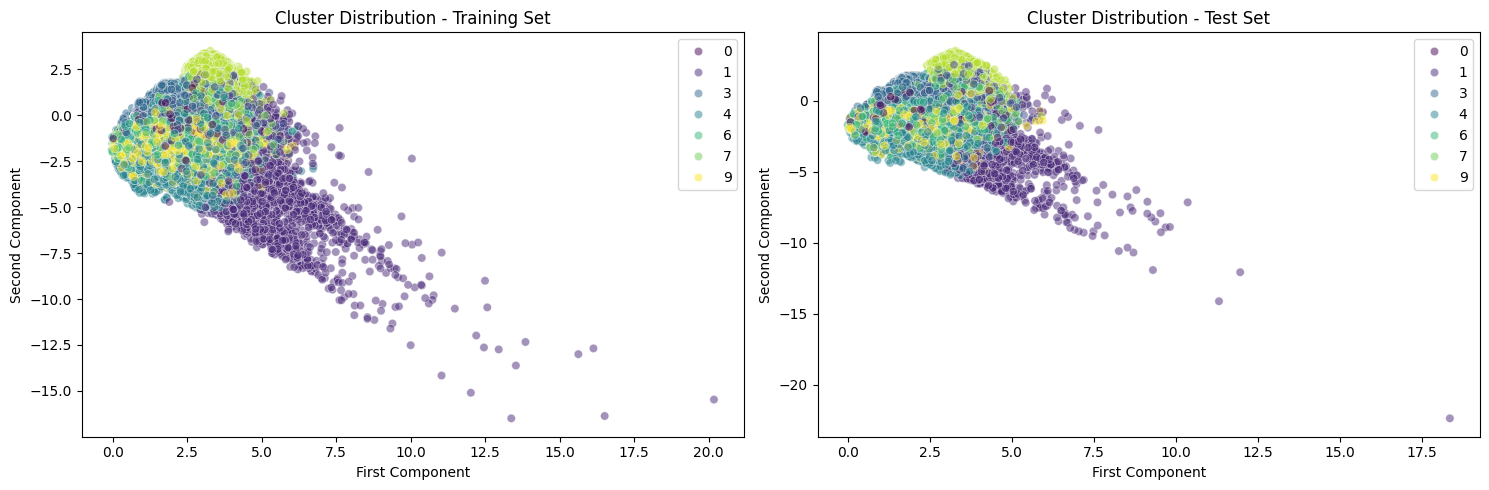


Cluster Analysis:
--------------------------------------------------

Cluster 0:
Size: 21454 samples (8.4%)
Center: (2.42, -0.21)
Spread: 0.90, 1.03

Cluster 1:
Size: 4892 samples (1.9%)
Center: (4.54, -4.14)
Spread: 1.33, 1.68

Cluster 2:
Size: 24576 samples (9.6%)
Center: (3.01, 0.60)
Spread: 0.83, 1.10

Cluster 3:
Size: 27159 samples (10.6%)
Center: (2.02, 0.70)
Spread: 0.64, 0.59

Cluster 4:
Size: 22977 samples (9.0%)
Center: (2.07, -2.26)
Spread: 0.92, 1.00

Cluster 5:
Size: 34622 samples (13.5%)
Center: (2.53, 0.14)
Spread: 0.90, 1.03

Cluster 6:
Size: 27132 samples (10.6%)
Center: (1.86, -1.32)
Spread: 0.87, 0.87

Cluster 7:
Size: 26586 samples (10.4%)
Center: (2.77, 0.27)
Spread: 0.92, 1.10

Cluster 8:
Size: 36622 samples (14.3%)
Center: (3.24, 2.08)
Spread: 0.38, 0.59

Cluster 9:
Size: 30019 samples (11.7%)
Center: (2.07, -1.50)
Spread: 0.96, 0.95

Evaluating metadata_mix strategy:

Clustering Results (k=5):
Silhouette Score: 0.438
Calinski-Harabasz Score: 118954.050

Cluster

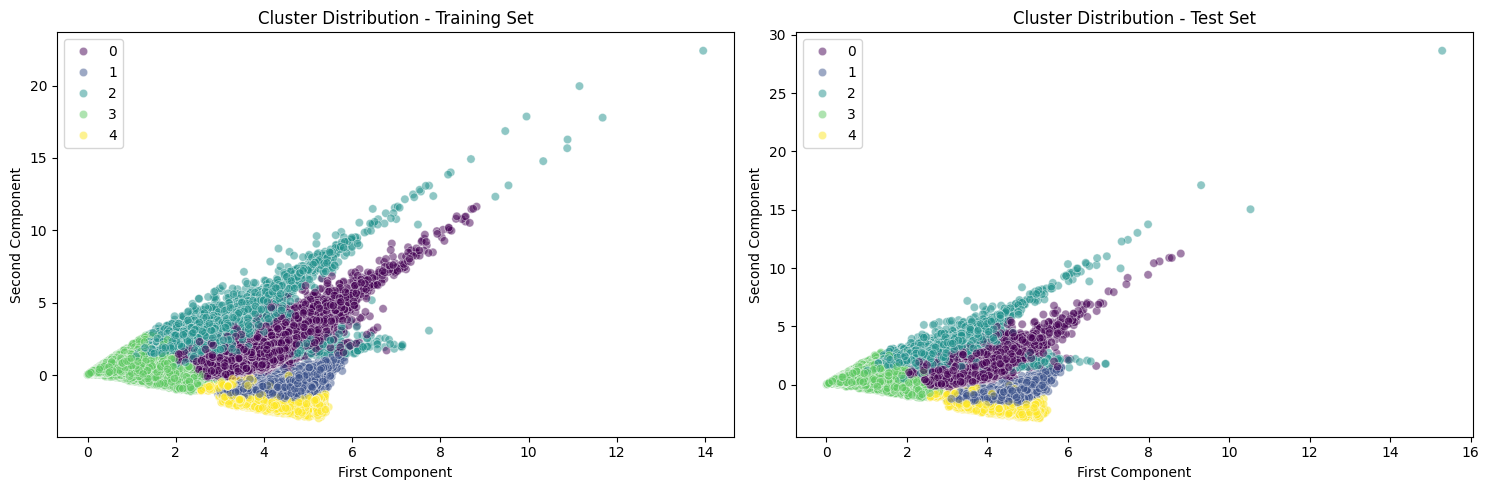


Cluster Analysis:
--------------------------------------------------

Cluster 0:
Size: 47944 samples (18.7%)
Center: (3.41, 1.20)
Spread: 0.72, 0.91

Cluster 1:
Size: 42112 samples (16.4%)
Center: (4.27, -0.91)
Spread: 0.49, 0.41

Cluster 2:
Size: 33571 samples (13.1%)
Center: (2.46, 2.36)
Spread: 0.81, 1.16

Cluster 3:
Size: 92956 samples (36.3%)
Center: (1.25, 0.37)
Spread: 0.73, 0.62

Cluster 4:
Size: 39456 samples (15.4%)
Center: (4.11, -1.81)
Spread: 0.62, 0.47

Dataset Shapes:
Full Training Set: (256039, 49)
Full Test Set: (64010, 49)
Cluster Training Set: (256039, 14)
Cluster Test Set: (64010, 14)


In [51]:
def process_features_for_clustering(train_df, test_df, feature_type='tfidf_sentiment'):
    if feature_type == 'tfidf_sentiment':
        feature_cols = ['Sentiment_Blob', 'Sentiment_VADER', 'sentiment_divergence',
                       'sentiment_intensity', 'verified_sentiment', 'time_sentiment',
                       'extreme_sentiment', 'number_reviews', 'text_length']
        tfidf = TfidfVectorizer(ngram_range=(1, 1))
        X_train = scipy.sparse.hstack([tfidf.fit_transform(train_df['text_processed']),
            scipy.sparse.csr_matrix(train_df[feature_cols].values)])
        X_test = scipy.sparse.hstack([
            tfidf.transform(test_df['text_processed']), scipy.sparse.csr_matrix(test_df[feature_cols].values)])
        return X_train, X_test, tfidf
        
    elif feature_type == 'topic_modeling':
        vectorizer = CountVectorizer(stop_words='english')
        X_train_dtm = vectorizer.fit_transform(train_df['text_processed'])
        X_test_dtm = vectorizer.transform(test_df['text_processed'])
        lda = LatentDirichletAllocation(n_components=10, random_state=42)
        return lda.fit_transform(X_train_dtm), lda.transform(X_test_dtm), None
        
    elif feature_type == 'hybrid':
        feature_cols = ['Sentiment_Blob', 'Sentiment_VADER', 'sentiment_divergence',
                       'number_reviews', 'text_length', 'extreme_sentiment']
        vectorizer = CountVectorizer()
        lda = LatentDirichletAllocation(n_components=8, random_state=42)
        return np.hstack([lda.fit_transform(vectorizer.fit_transform(train_df['text_processed'])),
            train_df[feature_cols].values]), np.hstack([
            lda.transform(vectorizer.transform(test_df['text_processed'])), test_df[feature_cols].values]), None
        
    elif feature_type == 'metadata_mix':
        feature_cols = ['Sentiment_Blob', 'Sentiment_VADER', 'sentiment_divergence', 
                       'sentiment_intensity', 'extreme_sentiment', 'text_length']
        return train_df[feature_cols].values, test_df[feature_cols].values, None

def create_cluster_features(df, cluster_results, distances, is_train=True, train_cluster_stats=None):
    df_copy = df.copy()
    original_index = df_copy.index.copy()
    if len(cluster_results) != len(df):
        raise ValueError(f"Length mismatch: cluster_results ({len(cluster_results)}) != df ({len(df)})")
    if distances.shape[0] != len(df):
        raise ValueError(f"Length mismatch: distances ({distances.shape[0]}) != df ({len(df)})")
    features_df = pd.DataFrame({'cluster': cluster_results, 'min_distance': distances.min(axis=1),
        'distance_mean': distances.mean(axis=1), 'second_closest': np.partition(distances, 1, axis=1)[:, 1]}, index=original_index)
    df_copy['cluster'] = features_df['cluster']
    df_copy['min_distance'] = features_df['min_distance']
    df_copy['distance_ratio'] = df_copy['min_distance'] / features_df['distance_mean']
    df_copy['second_closest'] = features_df['second_closest']
    df_copy['cluster_confidence'] = 1 - (df_copy['min_distance'] / df_copy['second_closest'])
    if is_train:
        cluster_rating_means = df_copy.groupby('cluster')['rating'].mean()
        train_cluster_stats = {'rating_means': cluster_rating_means}
    else:
        if train_cluster_stats is None:
            raise ValueError("train_cluster_stats must be provided for test data")
        cluster_rating_means = train_cluster_stats['rating_means']
    df_copy['cluster_rating_mean'] = df_copy['cluster'].map(cluster_rating_means)
    df_copy['rating_deviation'] = abs(df_copy['rating'] - df_copy['cluster_rating_mean'])
    df_copy.index = original_index
    return (df_copy, train_cluster_stats) if is_train else df_copy

def perform_clustering(X_train, X_test, max_clusters=10, n_components=50):
    scaler = StandardScaler(with_mean=False)
    svd = TruncatedSVD(n_components=min(n_components, X_train.shape[1] - 1), random_state=42)
    X_train_reduced = svd.fit_transform(scaler.fit_transform(X_train))
    X_test_reduced = svd.transform(scaler.transform(X_test))
    best_score = -1
    optimal_k = 2  
    silhouette_scores = []
    
    for k in range(2, max_clusters + 1):
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000)
        train_clusters = kmeans.fit_predict(X_train_reduced)
        try:
            score = silhouette_score(X_train_reduced, train_clusters, sample_size=10000)
            silhouette_scores.append(score)
            if score > best_score:
                best_score = score
                optimal_k = k
        except Exception as e:
            print(f"Warning: Error calculating score for k={k}: {str(e)}")
            continue
    
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    train_clusters = kmeans.fit_predict(X_train_reduced)
    test_clusters = kmeans.predict(X_test_reduced)
    metrics = {'silhouette_score': best_score,
        'calinski_harabasz_score': calinski_harabasz_score(X_train_reduced, train_clusters),
        'cluster_sizes': pd.Series(train_clusters).value_counts().to_dict()}
    
    print(f"\nClustering Results (k={optimal_k}):")
    print(f"Silhouette Score: {metrics['silhouette_score']:.3f}")
    print(f"Calinski-Harabasz Score: {metrics['calinski_harabasz_score']:.3f}")
    print("\nCluster Size Distribution:")
    for cluster, size in sorted(metrics['cluster_sizes'].items()):
        percentage = (size / len(train_clusters)) * 100
        print(f"Cluster {cluster}: {size} samples ({percentage:.1f}%)")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    sns.scatterplot(x=X_train_reduced[:, 0], y=X_train_reduced[:, 1], hue=train_clusters,
        palette='viridis', alpha=0.5, ax=ax1)
    ax1.set_title('Cluster Distribution - Training Set')
    ax1.set_xlabel('First Component')
    ax1.set_ylabel('Second Component')
    sns.scatterplot(x=X_test_reduced[:, 0], y=X_test_reduced[:, 1], hue=test_clusters,
        palette='viridis', alpha=0.5, ax=ax2)
    ax2.set_title('Cluster Distribution - Test Set')
    ax2.set_xlabel('First Component')
    ax2.set_ylabel('Second Component')
    
    plt.tight_layout()
    plt.show()
    
    print("\nCluster Analysis:")
    print("-" * 50)
    train_df_clusters = pd.DataFrame({'cluster': train_clusters,
        'component_1': X_train_reduced[:, 0], 'component_2': X_train_reduced[:, 1]})
    
    for cluster in range(optimal_k):
        cluster_data = train_df_clusters[train_df_clusters['cluster'] == cluster]
        print(f"\nCluster {cluster}:")
        print(f"Size: {len(cluster_data)} samples ({len(cluster_data)/len(train_clusters)*100:.1f}%)")
        print(f"Center: ({cluster_data['component_1'].mean():.2f}, {cluster_data['component_2'].mean():.2f})")
        print(f"Spread: {cluster_data['component_1'].std():.2f}, {cluster_data['component_2'].std():.2f}")
    
    return {'train_clusters': train_clusters, 'test_clusters': test_clusters,
        'train_distances': kmeans.transform(X_train_reduced),'test_distances': kmeans.transform(X_test_reduced),'optimal_k': optimal_k,
        'quality_metrics': metrics, 'reduced_data': {'train': X_train_reduced, 'test': X_test_reduced}}

def compare_and_export_clusters(train_df, test_df):
    comparison_results = {}
    topic_results = None
    for feature_type in ['tfidf_sentiment', 'topic_modeling', 'hybrid', 'metadata_mix']:
        print(f"\nEvaluating {feature_type} strategy:")
        try:
            X_train, X_test, _ = process_features_for_clustering(train_df, test_df, feature_type)
            results = perform_clustering(X_train, X_test)
            comparison_results[feature_type] = {'optimal_k': results['optimal_k'],
                'metrics': results['quality_metrics']}
            if feature_type == 'topic_modeling':
                topic_results = results
        except Exception as e:
            print(f"Warning: Strategy {feature_type} failed with error: {str(e)}")
            continue
    
    if topic_results is None:
        raise ValueError("Topic modeling strategy failed to produce results")
    
    train_with_clusters, train_stats = create_cluster_features(train_df,  topic_results['train_clusters'],
        topic_results['train_distances'], is_train=True)
    
    test_with_clusters = create_cluster_features(test_df, topic_results['test_clusters'], topic_results['test_distances'], 
        is_train=False, train_cluster_stats=train_stats)
    
    os.makedirs('data/clustering_results', exist_ok=True)
    required_features = ['sentiment_divergence', 'sentiment_intensity', 'sentiment_length_ratio',
                        'verification_encoded', 'verified_sentiment', 'time_sentiment',
                        'extreme_sentiment', 'row_id', 'cluster', 'min_distance', 'distance_ratio',
                        'second_closest', 'cluster_confidence', 'cluster_rating_mean',
                        'rating_deviation']
    
    missing_features = [f for f in required_features if f not in train_with_clusters.columns]
    if missing_features:
        print(f"Warning: Missing features in output: {missing_features}")
        required_features = [f for f in required_features if f not in missing_features]
    
    train_export = train_with_clusters[required_features]
    test_export = test_with_clusters[required_features]
    global train_df_full, test_df_full, train_df_cluster, test_df_cluster
    train_df_full = train_with_clusters
    test_df_full = test_with_clusters
    train_df_cluster = train_export
    test_df_cluster = test_export
    train_df_full.to_csv('data/train_post_cluster_full.csv', index=True)
    test_df_full.to_csv('data/test_post_cluster_full.csv', index=True)
    train_df_cluster.to_csv('data/train_post_cluster_reduced.csv', index=True)
    test_df_cluster.to_csv('data/test_post_cluster_reduced.csv', index=True)
    metadata = {'features': required_features, 'topic_modeling_results': {
            'optimal_k': topic_results['optimal_k'], 'metrics': topic_results['quality_metrics']},
        'strategy_comparison': comparison_results, 'shapes': {'train': train_df.shape, 'test': test_df.shape},
        'timestamp': datetime.now().isoformat()}
    with open('data/clustering_results/metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)
        
    return train_df_full, test_df_full, train_df_cluster, test_df_cluster, metadata

if __name__ == "__main__":
    train_df_full, test_df_full, train_df_cluster, test_df_cluster, metadata = compare_and_export_clusters(train_df, test_df)
    print("\nDataset Shapes:")
    print(f"Full Training Set: {train_df_full.shape}")
    print(f"Full Test Set: {test_df_full.shape}")
    print(f"Cluster Training Set: {train_df_cluster.shape}")
    print(f"Cluster Test Set: {test_df_cluster.shape}")

In [52]:
display(train_df_full.head())

,rating,location,username,number_reviews,verification,repeat_reviewer,repeat_reviewer_encoded,company,text,text_processed,...,verified_sentiment,time_sentiment,extreme_sentiment,cluster,min_distance,distance_ratio,second_closest,cluster_confidence,cluster_rating_mean,rating_deviation
61291,3,SE,Gunnar Samuelsson,5,Not Verified,repeat,1,CheckURL,I'm not so impressed by tests like this becaus...,not so impressed test like because some inform...,...,0.00000,7.503942,0,2,1.899224,0.506979,2.892487,0.343394,2.369380,0.630620
294741,5,US,Kyle,1,Not Verified,one-time,0,SurveyJunkie,Using Survey Junkie has given me the ability t...,using survey junkie ha given ability earn litt...,...,0.00000,6.679350,0,3,0.919684,0.254219,3.407232,0.730079,4.207081,0.792919
294425,3,US,Xinyi Ge,1,Not Verified,one-time,0,SurveyJunkie,Some awesome surveys really asking for our opi...,some awesome survey really asking our opinion ...,...,0.00000,9.107142,0,3,1.816855,0.575357,2.745123,0.338152,4.207081,1.207081
46579,2,US,Tim Schulte,1,Invited,one-time,0,Quicken,Every time I update my bank info the program l...,every time update bank info program lock up sh...,...,0.00000,0.724433,0,8,1.047926,0.230842,4.296050,0.756072,2.601782,0.601782
232728,5,US,Christian Sanabria,1,Verified,one-time,0,CASETiFY,Casetify is great their cases are so protectiv...,casetify great their case so protective got an...,...,0.75095,12.015200,1,5,0.771393,0.175125,4.636819,0.833637,4.095507,0.904493


In [53]:
#Data Leakage detection
def detect_leakage(train_df, test_df, checkpoint_name="", print_details=True):
    print(f"Shape of train_df: {train_df.shape if train_df is not None else 'None'}")
    print(f"Shape of test_df: {test_df.shape if test_df is not None else 'None'}")
    print(f"Columns in train_df: {train_df.columns.tolist() if train_df is not None else 'None'}")
    findings = {}
    has_leakage = False
    if print_details:
        print(f"Checking for leakage at checkpoint: {checkpoint_name}")
    if train_df is None or test_df is None:
        print("Error: train_df or test_df is None")
        return findings, has_leakage
    train_idx = set(train_df.index)
    test_idx = set(test_df.index)
    idx_overlap = train_idx.intersection(test_idx)
    findings['index_overlap'] = len(idx_overlap)
    if len(idx_overlap) > 0:
        has_leakage = True
        if print_details:
            print(f"WARNING: Found {len(idx_overlap)} overlapping indices")
            print(f"First 5 overlapping indices: {list(idx_overlap)[:5]}")
    if 'rating' in train_df.columns:
        train_features = train_df.drop('rating', axis=1)
        test_features = test_df.drop('rating', axis=1)
    else:
        train_features = train_df
        test_features = test_df
    common_columns = list(set(train_features.columns) & set(test_features.columns))
    numeric_columns = []
    for col in common_columns:
        if train_features[col].dtype in ['int64', 'float64', 'int32', 'float32']:
            numeric_columns.append(col)
    if common_columns:
        train_subset = train_features[common_columns]
        test_subset = test_features[common_columns]
        train_rows = set(map(tuple, train_subset.values))
        test_rows = set(map(tuple, test_subset.values))
        duplicate_rows = train_rows.intersection(test_rows)
        findings['duplicate_rows'] = len(duplicate_rows)
        if len(duplicate_rows) > 0:
            has_leakage = True
            if print_details:
                print(f"WARNING: Found {len(duplicate_rows)} duplicate rows between train and test")
    if 'rating' in train_df.columns and 'rating' in test_df.columns:
        train_dist = train_df['rating'].value_counts(normalize=True)
        test_dist = test_df['rating'].value_counts(normalize=True)
        dist_diff = abs(train_dist - test_dist).mean()
        findings['target_distribution_difference'] = dist_diff
        if print_details:
            print("\nTarget Distribution Check:")
            print("Train distribution:")
            print(train_dist)
            print("\nTest distribution:")
            print(test_dist)
            print(f"\nDistribution difference: {dist_diff:.6f}")
            if dist_diff < 0.001:
                print("Note: Similar distributions likely due to stratified sampling")
    suspicious_features = []
    for col in numeric_columns:
        try:
            train_stats = train_features[col].agg(['mean', 'std', 'min', 'max'])
            test_stats = test_features[col].agg(['mean', 'std', 'min', 'max'])
            stats_similar = all(abs(float(train_stats[stat]) - float(test_stats[stat])) < 1e-10 
                for stat in ['mean', 'std', 'min', 'max'])
            if stats_similar:
                suspicious_features.append(col)
                has_leakage = True
        except (TypeError, ValueError):
            continue
    
    findings['suspicious_features'] = suspicious_features
    if suspicious_features and print_details:
        print(f"\nWARNING: Found {len(suspicious_features)} features with identical statistics:")
        print(suspicious_features)
    if print_details:
        print("\nLeakage Detection Summary:")
        print(f"Has leakage: {has_leakage}")
        print(f"Overlapping indices: {findings['index_overlap']}")
        print(f"Duplicate rows: {findings['duplicate_rows']}")
        print(f"Suspicious features: {len(findings['suspicious_features'])}")
        print("-" * 50)
    return findings, has_leakage

findings, has_leakage = detect_leakage(train_df_full, test_df_full)

Shape of train_df: (256039, 49)
Shape of test_df: (64010, 49)
Columns in train_df: ['rating', 'location', 'username', 'number_reviews', 'verification', 'repeat_reviewer', 'repeat_reviewer_encoded', 'company', 'text', 'text_processed', 'text_length', 'text_word_length', 'Sentiment_Blob', 'Sentiment_Blob_cat', 'Sentiment_VADER', 'Sentiment_VADER_cat', 'subject', 'subject_processed', 'subject_length', 'subject_word_length', 'answer', 'answer_processed', 'answered_encoded', 'date_of_experience', 'date_posted', 'local_date_posted', 'month_local', 'local_hour', 'time_of_day', 'day_of_week_posted', 'day_type', 'days_between_experience_and_post', 'review_time', 'review_time_encoded', 'punctuation_counts', 'sentiment_divergence', 'sentiment_intensity', 'sentiment_length_ratio', 'verification_encoded', 'verified_sentiment', 'time_sentiment', 'extreme_sentiment', 'cluster', 'min_distance', 'distance_ratio', 'second_closest', 'cluster_confidence', 'cluster_rating_mean', 'rating_deviation']
Checkin

In [54]:
display(train_df_cluster.head())

,sentiment_divergence,sentiment_intensity,sentiment_length_ratio,verification_encoded,verified_sentiment,time_sentiment,extreme_sentiment,cluster,min_distance,distance_ratio,second_closest,cluster_confidence,cluster_rating_mean,rating_deviation
61291,0.882817,0.441408,0.008174,0,0.00000,7.503942,0,2,1.899224,0.506979,2.892487,0.343394,2.369380,0.630620
294741,0.429650,0.371075,0.028544,0,0.00000,6.679350,0,3,0.919684,0.254219,3.407232,0.730079,4.207081,0.792919
294425,0.809407,0.569196,0.004447,0,0.00000,9.107142,0,3,1.816855,0.575357,2.745123,0.338152,4.207081,1.207081
46579,0.160985,0.080493,0.003096,0,0.00000,0.724433,0,8,1.047926,0.230842,4.296050,0.756072,2.601782,0.601782
232728,0.201900,0.750950,0.062579,1,0.75095,12.015200,1,5,0.771393,0.175125,4.636819,0.833637,4.095507,0.904493


In [55]:
#Data Leakage detection
def detect_leakage(train_df, test_df, checkpoint_name="", print_details=True):
    print(f"Shape of train_df: {train_df.shape if train_df is not None else 'None'}")
    print(f"Shape of test_df: {test_df.shape if test_df is not None else 'None'}")
    print(f"Columns in train_df: {train_df.columns.tolist() if train_df is not None else 'None'}")
    findings = {}
    has_leakage = False
    if print_details:
        print(f"Checking for leakage at checkpoint: {checkpoint_name}")
    if train_df is None or test_df is None:
        print("Error: train_df or test_df is None")
        return findings, has_leakage
    train_idx = set(train_df.index)
    test_idx = set(test_df.index)
    idx_overlap = train_idx.intersection(test_idx)
    findings['index_overlap'] = len(idx_overlap)
    if len(idx_overlap) > 0:
        has_leakage = True
        if print_details:
            print(f"WARNING: Found {len(idx_overlap)} overlapping indices")
            print(f"First 5 overlapping indices: {list(idx_overlap)[:5]}")
    if 'rating' in train_df.columns:
        train_features = train_df.drop('rating', axis=1)
        test_features = test_df.drop('rating', axis=1)
    else:
        train_features = train_df
        test_features = test_df
    common_columns = list(set(train_features.columns) & set(test_features.columns))
    numeric_columns = []
    for col in common_columns:
        if train_features[col].dtype in ['int64', 'float64', 'int32', 'float32']:
            numeric_columns.append(col)
    if common_columns:
        train_subset = train_features[common_columns]
        test_subset = test_features[common_columns]
        train_rows = set(map(tuple, train_subset.values))
        test_rows = set(map(tuple, test_subset.values))
        duplicate_rows = train_rows.intersection(test_rows)
        findings['duplicate_rows'] = len(duplicate_rows)
        if len(duplicate_rows) > 0:
            has_leakage = True
            if print_details:
                print(f"WARNING: Found {len(duplicate_rows)} duplicate rows between train and test")
    if 'rating' in train_df.columns and 'rating' in test_df.columns:
        train_dist = train_df['rating'].value_counts(normalize=True)
        test_dist = test_df['rating'].value_counts(normalize=True)
        dist_diff = abs(train_dist - test_dist).mean()
        findings['target_distribution_difference'] = dist_diff
        if print_details:
            print("\nTarget Distribution Check:")
            print("Train distribution:")
            print(train_dist)
            print("\nTest distribution:")
            print(test_dist)
            print(f"\nDistribution difference: {dist_diff:.6f}")
            if dist_diff < 0.001:
                print("Note: Similar distributions likely due to stratified sampling")
    suspicious_features = []
    for col in numeric_columns:
        try:
            train_stats = train_features[col].agg(['mean', 'std', 'min', 'max'])
            test_stats = test_features[col].agg(['mean', 'std', 'min', 'max'])
            stats_similar = all(abs(float(train_stats[stat]) - float(test_stats[stat])) < 1e-10 
                for stat in ['mean', 'std', 'min', 'max'])
            if stats_similar:
                suspicious_features.append(col)
                has_leakage = True
        except (TypeError, ValueError):
            continue
    
    findings['suspicious_features'] = suspicious_features
    if suspicious_features and print_details:
        print(f"\nWARNING: Found {len(suspicious_features)} features with identical statistics:")
        print(suspicious_features)
    if print_details:
        print("\nLeakage Detection Summary:")
        print(f"Has leakage: {has_leakage}")
        print(f"Overlapping indices: {findings['index_overlap']}")
        print(f"Duplicate rows: {findings['duplicate_rows']}")
        print(f"Suspicious features: {len(findings['suspicious_features'])}")
        print("-" * 50)
    return findings, has_leakage

findings, has_leakage = detect_leakage(train_df_cluster, test_df_cluster)

Shape of train_df: (256039, 14)
Shape of test_df: (64010, 14)
Columns in train_df: ['sentiment_divergence', 'sentiment_intensity', 'sentiment_length_ratio', 'verification_encoded', 'verified_sentiment', 'time_sentiment', 'extreme_sentiment', 'cluster', 'min_distance', 'distance_ratio', 'second_closest', 'cluster_confidence', 'cluster_rating_mean', 'rating_deviation']
Checking for leakage at checkpoint: 

Leakage Detection Summary:
Has leakage: True
Overlapping indices: 0
Duplicate rows: 448
Suspicious features: 0
--------------------------------------------------
